In [ ]:
# keras packages
from tensorflow.keras.applications import ResNet50
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
from tensorflow.keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Dropout,Flatten,BatchNormalization
from keras.datasets import mnist


# sklearn packages
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.model_selection import train_test_split

import random
import numpy as np
import cv2
import os
from imutils import paths
import progressbar

# drawing packages
import matplotlib.pyplot as plt
%matplotlib inline

#basic tool
import pandas as pd
import sys
import io

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load data & Data Preprocessing

In [ ]:
np.random.seed(161)

# load data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.20, random_state = 31)

x_train=[cv2.cvtColor(cv2.resize(i,(32,32)),cv2.COLOR_GRAY2BGR)for i in x_train]
x_train=np.concatenate([arr[np.newaxis]for arr in x_train]).astype('float32')
x_train=x_train/255

x_val=[cv2.cvtColor(cv2.resize(i,(32,32)),cv2.COLOR_GRAY2BGR)for i in x_val]
x_val=np.concatenate([arr[np.newaxis]for arr in x_val]).astype('float32')
x_val=x_val/255

x_test=[cv2.cvtColor(cv2.resize(i,(32,32)),cv2.COLOR_GRAY2BGR)for i in x_test]
x_test=np.concatenate([arr[np.newaxis]for arr in x_test]).astype('float32')
x_test=x_test/255

In [ ]:
#construct a non-equilibrium sample
def imbalanceData(__format,X_train,y_train):
   train_classes, train_class_counts=np.unique(y_train, return_counts=True)
   nb_train_classes = len(train_classes)
   class_indices = [np.where(y_train == i)[0] for i in range(nb_train_classes)]
   imbal_class_indices = [class_idx[:class_count] for class_idx, class_count in zip(class_indices, __format)]
   imbal_class_indices = np.hstack(imbal_class_indices)
   y = y_train[imbal_class_indices]
   X = x_train[imbal_class_indices]  
   return X,y

In [ ]:
imbal_class_counts=[250,750,1250,1750,2250,2750,3250,3750,4250,5000]
imbal_class_counts=[int(i * 4/5) for i in imbal_class_counts]
x_train,y_train=imbalanceData(imbal_class_counts,x_train,y_train)

In [ ]:
# Y one hot
y_train_oh = to_categorical(y_train)
y_val_oh = to_categorical(y_val)
y_test_oh = to_categorical(y_test)

## Base Model

In [ ]:
# Load ResNet50 that does not contain the top layer as the baseModel
baseModel = ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(32, 32,3)))

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
def headmodel(baseModel):
    # Add a new layer based on baseModel
    headModel = baseModel.output
    
    # New top layers
    headModel = Flatten()(headModel)
    headModel = Dense(10, activation="softmax")(headModel)
    return headModel

In [ ]:
headModel = headmodel(baseModel)
model = Model(inputs=baseModel.input, outputs=headModel)

In [ ]:
# Callback function for saving model snapshot
modelname = "cifar10-resnet50-weights-{epoch:03d}-{val_loss:.4f}.hdf5"

#When the monitor parameter is val loss, the mode option is min; 
#save_best_only: When set to True, only the model with the best performance on the validation set will be saved
checkpoint = ModelCheckpoint(modelname, monitor="val_loss", mode="min", save_best_only=True)

# Freeze the parameters of all layers of baseModel without learning
for layer in baseModel.layers:
    layer.trainable = False

# Compile
# The learning rate is adjusted to 0.01; 
# the optimizer is set to SGD(lr=learning rate, decay=learning rate/nb_ephoch, momentum=0.9, nesterov=True) st. The learning rate changes with the training round
sgd = SGD(lr=0.01, decay=0.01/20, momentum=0.9, nesterov=True) 
model.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
H = model.fit(x_train, y_train_oh, batch_size=32,
                        validation_data=(x_val, y_val_oh),
                        callbacks=[checkpoint],
                        epochs=20)


Epoch 1/20
632/632 [==============================] - ETA: 0s - loss: 4.0668 - accuracy: 0.6585

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


632/632 [==============================] - 61s 46ms/step - loss: 4.0668 - accuracy: 0.6585 - val_loss: 1.0118 - val_accuracy: 0.7500
Epoch 2/20
632/632 [==============================] - 29s 46ms/step - loss: 0.5676 - accuracy: 0.8333 - val_loss: 0.9700 - val_accuracy: 0.7459
Epoch 3/20
632/632 [==============================] - 29s 45ms/step - loss: 0.4538 - accuracy: 0.8589 - val_loss: 1.2353 - val_accuracy: 0.6704
Epoch 4/20
632/632 [==============================] - 27s 43ms/step - loss: 0.3967 - accuracy: 0.8756 - val_loss: 0.7166 - val_accuracy: 0.8027
Epoch 5/20
632/632 [==============================] - 27s 43ms/step - loss: 0.3575 - accuracy: 0.8853 - val_loss: 0.5982 - val_accuracy: 0.8205
Epoch 6/20
632/632 [==============================] - 27s 43ms/step - loss: 0.3342 - accuracy: 0.8921 - val_loss: 0.5403 - val_accuracy: 0.8409
Epoch 7/20
632/632 [==============================] - 28s 45ms/step - loss: 0.3178 - accuracy: 0.8963 - val_loss: 0.6811 - val_accuracy: 0.7868
Epo

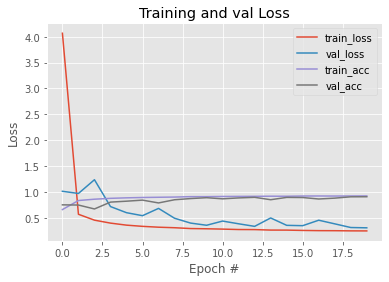

In [ ]:
# Draw loss and accuracy curves
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 20), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 20), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 20), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.title("Training and val Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Update the training set based on F1-score

In [ ]:
# Classified evaluation report
preds = model.predict(x_val, batch_size=32)
print(classification_report(y_val_oh.argmax(axis=1),preds.argmax(axis=1), digits=4))

              precision    recall  f1-score   support

           0     0.9895    0.7317    0.8413      1163
           1     0.9866    0.9800    0.9833      1352
           2     0.9491    0.8607    0.9027      1170
           3     0.9279    0.8816    0.9041      1182
           4     0.9129    0.9231    0.9180      1158
           5     0.8897    0.8814    0.8856      1071
           6     0.8301    0.9800    0.8988      1251
           7     0.9336    0.9456    0.9396      1324
           8     0.8257    0.8884    0.8559      1093
           9     0.8580    0.9628    0.9074      1236

    accuracy                         0.9064     12000
   macro avg     0.9103    0.9035    0.9037     12000
weighted avg     0.9116    0.9064    0.9058     12000



In [ ]:
final_report = classification_report(y_val_oh.argmax(axis=1),preds.argmax(axis=1), digits=4)
report_pd = pd.read_csv(io.StringIO(final_report), delim_whitespace=True, error_bad_lines=False)

b'Skipping line 15: expected 5 fields, saw 6\nSkipping line 16: expected 5 fields, saw 6\n'


In [ ]:
report_re = report_pd[:10]
report_re = report_re.reset_index()
report_re = report_re[["index", "f1-score"]]
report_re.columns=['class_name','f1_score']
#1-F1 score used for uodating the sample size 
report_re['1-f1_score'] = 1-report_re['f1_score']
ds_sum = report_re['1-f1_score'].sum() 
report_re["class_weight"] = report_re["1-f1_score"]/ds_sum
report_re["re_class_counts"] = (report_re["1-f1_score"]/ds_sum)*len(x_train)
report_re["row_distribution"] = pd.DataFrame(imbal_class_counts)
report_re['tt'] = report_re['re_class_counts'] - report_re['row_distribution']
report_re.loc[report_re["tt"]<0,"tt"] = report_re["re_class_counts"]
report_re002 = report_re[["class_name","class_weight","re_class_counts","row_distribution","tt"]]
report_re002["tt"] = round(report_re002["tt"])
report_re002.columns=['class_name',"class_weight","re_class_counts","row_distribution","update_num"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
def choosingImages(x_train,y_train):
  c_X_train=[]
  for i in range(10):
    # print(i)
    class_indices_=[np.where(y_train == i)[0]]
    x_train_ = x_train[class_indices_]
    c_X_train.append(x_train_)
  return c_X_train

In [ ]:
X_train_list=choosingImages(x_train,y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


In [ ]:
#Data augmentation function
def data_augmentation(img, number):
  image = np.expand_dims(img, axis=0)
  # Instantiate the image generator class to specify some common image augmentation parameters
  aug = ImageDataGenerator(rotation_range=30,
                width_shift_range=0.1,
                height_shift_range=0.1, 
                shear_range=0.2, 
                zoom_range=0.2,
                horizontal_flip=True,
                fill_mode="nearest")
    
  imageGen = aug.flow(image, batch_size=1)

  total = 0
  imglist = []
  for x in imageGen:
    total += 1
    imglist.append(x)
    if total == number:
      break

  # imgback = np.array(imglist)
  return imglist

In [ ]:
def img_add(x_train_i, num):
  img_list = []
  for image in x_train_i:
    img_list_i = data_augmentation(image, 20)
    img_list.extend(img_list_i)
  
  imgback = random.sample(img_list, num)
  imgback = np.array(imgback)
  final_x_train_i = np.vstack((x_train_i,imgback.squeeze()))
  return final_x_train_i

In [ ]:
report_re002

,class_name,class_weight,re_class_counts,row_distribution,update_num
0,0,0.164746,3327.872937,200,3128.0
1,1,0.017336,350.192048,600,350.0
2,2,0.101007,2040.340496,1000,1040.0
3,3,0.099554,2010.983079,1400,611.0
4,4,0.085124,1719.505865,1800,1720.0
5,5,0.118758,2398.920378,2200,199.0
6,6,0.105056,2122.121873,2600,2122.0
7,7,0.062701,1266.562857,3000,1267.0
8,8,0.149590,3021.717014,3400,3022.0
9,9,0.096128,1941.783453,4000,1942.0


In [ ]:
#Update the number of samples based on the results of report_re002
#If re_class_counts> row_distribution, data augmentation update_num number of samples
#If re_class_counts <row_distribution, randomly sample update_num number of samples

ds_change_0 = img_add(X_train_list[0], 3128)
#ds_change_1 = img_add(X_train_list[1], 1315)
ds_change_1 = np.array(random.sample(list(X_train_list[1]), 350))
ds_change_2 = img_add(X_train_list[2], 1040)
ds_change_3 = img_add(X_train_list[3], 611)

#ds_change_4 = img_add(X_train_list[4], 164)
ds_change_4 = np.array(random.sample(list(X_train_list[4]), 1720))

ds_change_5 = img_add(X_train_list[5], 199)
#ds_change_5 = np.array(random.sample(list(X_train_list[5]), 2728))

ds_change_6 = np.array(random.sample(list(X_train_list[6]), 2122))
ds_change_7 = np.array(random.sample(list(X_train_list[7]), 1267))
ds_change_8 = np.array(random.sample(list(X_train_list[8]), 3022))
ds_change_9 = np.array(random.sample(list(X_train_list[9]), 1942))

In [ ]:
x_train_new = np.vstack((ds_change_0,ds_change_1))
x_train_new = np.vstack((x_train_new,ds_change_2))
x_train_new = np.vstack((x_train_new,ds_change_3))
x_train_new = np.vstack((x_train_new,ds_change_4))
x_train_new = np.vstack((x_train_new,ds_change_5))
x_train_new = np.vstack((x_train_new,ds_change_6))
x_train_new = np.vstack((x_train_new,ds_change_7))
x_train_new = np.vstack((x_train_new,ds_change_8))
x_train_new = np.vstack((x_train_new,ds_change_9))

In [ ]:
def new_array(row,nmb):
  new_arr = np.zeros((row,1))
  for i in range(row):
    new_arr[i] = np.array([nmb])
  return new_arr

def change_y(update__):
  """
  update_list:The update size relate to F1-score
  """
  update_list=[]
  for i in range(len(update__)):
    _y=new_array(update__[i],i)
    update_list.append(_y)
  y_train_new = np.vstack((update_list[0],update_list[1]))
  for j in range(len(update_list)):
     if(j>=2):
      y_train_new = np.vstack((y_train_new,update_list[j]))

  #One-hot coding
  y_train_new_oh = to_categorical(y_train_new)

  return y_train_new_oh

In [ ]:
#Corresponding sequence input y number of samples input according to the following conditions
#If re_class_counts> row_distribution, number(y) = update_num + row_distribution
#If re_class_counts <row_distribution, number(y) = update_num
y_train_new_oh = change_y([3328,350,2040,2011,1720,2399,2122,1267,3022,1942])

In [ ]:
# Allow the parameters of all layers of baseModel to be learnable
for layer in baseModel.layers:
    layer.trainable = True

In [ ]:
# Callback function for saving model snapshot
modelname = "final_cifar10-resnet50-weights-{epoch:03d}-{val_loss:.4f}.hdf5" 
#Note that you need to change the name when you save again later,otherwise it will overwrite the previously saved file with the same name
checkpoint = ModelCheckpoint(modelname, monitor="val_loss", mode="min", save_best_only=True)

In [ ]:
# Compile
sgd = SGD(lr=0.001, decay=0.001 / 5, momentum=0.9, nesterov=True)
model.compile(loss="categorical_crossentropy", optimizer=sgd,metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
H = model.fit(x_train_new, y_train_new_oh, batch_size=32,
                        validation_data=(x_val, y_val_oh),
                        callbacks=[checkpoint],
                        epochs=5)

Epoch 1/5
632/632 [==============================] - ETA: 0s - loss: 0.7452 - accuracy: 0.8286

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


632/632 [==============================] - 82s 117ms/step - loss: 0.7452 - accuracy: 0.8286 - val_loss: 2.0428 - val_accuracy: 0.2772
Epoch 2/5
632/632 [==============================] - 74s 116ms/step - loss: 0.1875 - accuracy: 0.9455 - val_loss: 0.0881 - val_accuracy: 0.9725
Epoch 3/5
632/632 [==============================] - 73s 116ms/step - loss: 0.1242 - accuracy: 0.9635 - val_loss: 0.0701 - val_accuracy: 0.9783
Epoch 4/5
632/632 [==============================] - 74s 116ms/step - loss: 0.0797 - accuracy: 0.9758 - val_loss: 0.0571 - val_accuracy: 0.9827
Epoch 5/5
632/632 [==============================] - 74s 117ms/step - loss: 0.0595 - accuracy: 0.9825 - val_loss: 0.0539 - val_accuracy: 0.9836


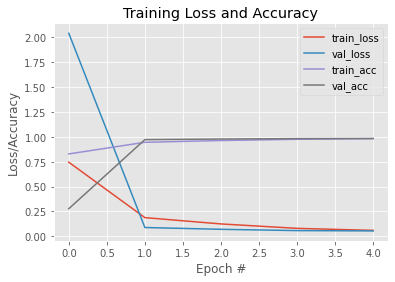

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 5), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 5), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 5), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 5), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

In [ ]:
print("train_loss: ",H.history["loss"])
print("val_loss: ",H.history["val_loss"])
print("train_accuracy: ",H.history["accuracy"])
print("val_accuracy: ",H.history["val_accuracy"])

train_loss:  [0.7452309131622314, 0.1875341385602951, 0.1242365911602974, 0.07966700196266174, 0.05945723503828049]
val_loss:  [2.0427684783935547, 0.0880860835313797, 0.07009933888912201, 0.057092975825071335, 0.05392588675022125]
train_accuracy:  [0.8285728693008423, 0.9455472230911255, 0.9634671807289124, 0.9757933020591736, 0.982525646686554]
val_accuracy:  [0.2772499918937683, 0.9725000262260437, 0.9783333539962769, 0.9826666712760925, 0.9835833311080933]


In [ ]:
#Classification evaluation report
preds = model.predict(x_val, batch_size=32)
print(classification_report(y_val_oh.argmax(axis=1),preds.argmax(axis=1), digits=4))

              precision    recall  f1-score   support

           0     0.9940    0.9905    0.9922      1163
           1     0.9962    0.9808    0.9884      1352
           2     0.9768    0.9709    0.9739      1170
           3     0.9799    0.9882    0.9840      1182
           4     0.9811    0.9888    0.9849      1158
           5     0.9586    0.9944    0.9762      1071
           6     0.9920    0.9896    0.9908      1251
           7     0.9924    0.9804    0.9863      1324
           8     0.9782    0.9863    0.9822      1093
           9     0.9820    0.9684    0.9752      1236

    accuracy                         0.9836     12000
   macro avg     0.9831    0.9838    0.9834     12000
weighted avg     0.9837    0.9836    0.9836     12000



According to the F1-score results, the training set is continuously updated and iteratively learned until the specified number of iterations is reached.

## Model Evaluation

In [ ]:
# Results on the test set
preds = model.predict(x_test, batch_size=32)
print(classification_report(y_test_oh.argmax(axis=1),preds.argmax(axis=1), digits=4))

              precision    recall  f1-score   support

           0     0.9990    0.9898    0.9944       980
           1     0.9973    0.9868    0.9920      1135
           2     0.9787    0.9777    0.9782      1032
           3     0.9812    0.9822    0.9817      1010
           4     0.9959    0.9857    0.9908       982
           5     0.9591    0.9989    0.9786       892
           6     0.9895    0.9854    0.9874       958
           7     0.9855    0.9883    0.9869      1028
           8     0.9887    0.9856    0.9871       974
           9     0.9871    0.9851    0.9861      1009

    accuracy                         0.9864     10000
   macro avg     0.9862    0.9866    0.9863     10000
weighted avg     0.9865    0.9864    0.9864     10000

